# 1) Import Libraries

In [ ]:
!pip install copick git+https://github.com/copick/copick-utils.git scikit-image cupy-cuda12x torch torchvision tqdm matplotlib

import numpy as np
from glob import glob
import os
import pandas as pd
import zarr
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D

  Cloning https://github.com/copick/copick-utils.git to /tmp/pip-req-build-4sqrifvh
  Running command git clone --filter=blob:none --quiet https://github.com/copick/copick-utils.git /tmp/pip-req-build-4sqrifvh
  Resolved https://github.com/copick/copick-utils.git to commit 79315f3fca71ebfaaff54198b3e08a3bd2ebc63f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of fsspec[s3] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.

# 2) Load Zarr Data and Centroids (from JSON)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_zarr(run: str) -> zarr.hierarchy.Group:

    """Reads a zarr data (we only use the denoised.zarr files)"""

    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

def read_run(run: str) -> pd.DataFrame:

    """Creates a dataframe with the coordinates of the
    centroids of the particles.
    It uses the information in the overlay.
    It needs to know the name of
    an experiment (also called run)
    We get the name of the experiment by selecting an element of the list run"""

    paths = glob(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json")
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    return df

# 3) Data Preprocessing

## Convert Centroids to Voxels

In [ ]:
def map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=(100, 100, 100)):

    """It creates a 3D image (volumen) using the information of the dataframe about
    the centroids of the particles.
    Right now, it only works for ribosome.
    You can change ribosome for another particle.
    Or you can create a function that multilabels the voxels.
    """

    voxel_labels = np.zeros(volume_shape, dtype=int)
    for _, row in df.iterrows():
        x, y, z = [int(row[axis] / voxel_spacing) for axis in ['x', 'y', 'z']]
        voxel_labels[z, y, x] = 1 if row['pickable_object_name'] == 'ribosome' else 0
    return voxel_labels

## Expand Centroids into Blobs

In [ ]:
def expand_labels_with_blobs(voxel_labels, radius):

    """Expands labeled centroids (value = 1) in a 3D numpy array into spherical blobs."""

    radius = int(radius)
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    sphere = distance <= radius

    expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
    centroids = np.argwhere(voxel_labels == 1)

    for centroid in centroids:
        cz, cy, cx = centroid
        z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
        y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
        x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
        roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
        roi[sphere] = 1
    return expanded_labels

## Create Subvolumes

In [ ]:
def preprocess_and_filter_subvolumes(zarr_data, labels, target_shape=(32, 32, 32), background_fraction=0.2, normalize=True):

    """
    Generate sub-volumes and corresponding voxel-wise labels,
    keeping those sub volumes with at least one `1` label and a random fraction of `0`-only sub volumes. This means that
    the functin will filter out the sub-volumes that do not have relevant data.
    A subvolume does not have relevant data if the associated labels do not indicate the
    presence of a particle there.
    You can choose to keep some irrelevant data, for that ue the background_fraction argument.

    Arguments:
        zarr_data: 3D numpy array of voxel data.
        labels: 3D numpy array of voxel labels.
        target_shape: Tuple defining the shape of each sub-volume.
        background_fraction: Fraction of `0`-only sub-volumes to include.

    Returns:
        filtered_volumes: Filtered sub-volumes.
        filtered_labels: Corresponding labels for the filtered sub-volumes.
    """

    sub_volumes = []
    sub_labels = []
    background_volumes = []
    background_labels = []

    for x in range(0, zarr_data.shape[0] - target_shape[0] + 1, target_shape[0]):
        for y in range(0, zarr_data.shape[1] - target_shape[1] + 1, target_shape[1]):
            for z in range(0, zarr_data.shape[2] - target_shape[2] + 1, target_shape[2]):
                crop = zarr_data[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                crop_label = labels[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                if np.any(crop_label == 1):
                    sub_volumes.append(crop)
                    sub_labels.append(crop_label)
                else:
                    background_volumes.append(crop)
                    background_labels.append(crop_label)

    if background_fraction > 0 and len(background_volumes) > 0:
        sample_size = int(len(sub_volumes) * background_fraction)
        sampled_indices = np.random.choice(len(background_volumes), size=sample_size, replace=False)
        sub_volumes.extend([background_volumes[i] for i in sampled_indices])
        sub_labels.extend([background_labels[i] for i in sampled_indices])
    if normalize:
        return ((np.array(sub_volumes) - np.min(np.array(sub_volumes))) / (np.max(np.array(sub_volumes)) - np.min(np.array(sub_volumes)))), np.array(sub_labels)
    return np.array(sub_volumes), np.array(sub_labels)

In [ ]:
# Creates a list with the names of the experiments
runs = sorted(glob('/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
print(runs)
print(f"We use this experiment {runs[6]}, but you should be able \nto also add information of the other experiments")

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
We use this experiment TS_99_9, but you should be able 
to also add information of the other experiments


In [ ]:
# Once you know the name of the experiment you can open a zarr file (the file with the 3d image, also caled volume)
zarr_data_nparray = read_zarr(runs[6])

In [ ]:
# In the "overlay" of an experiment you have information about the centroids, it is in json format
# You create a df with the json file

df = read_run(runs[6])

# Now create a 3d target image that will have the labels
# The function map_overlay_to_voxels is only reading the centroids of the ribosome particle, you can change that
voxel_labels = map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=zarr_data_nparray["0"].shape) #"0" means the level of 'zooming', we always use 0, which is the maximum

In [ ]:
# In the voxel_labels only the center of a particle is labeled,
# but we could expand the label to fill a sphere
# to make learning easier
radius_ribosome = 7  # Radius in voxels
voxel_labels_blob = expand_labels_with_blobs(voxel_labels, radius=radius_ribosome)

Although the 3d image (called volume) of an experiment is useful for visualization,
it might be too big for your memory when you try to train a model.
A way to deal with this problem, is to cut the 3d images into 3d patches (called subvolumes)

In [ ]:
# Create sub volumes and their associated targets
filtered_volumes, filtered_labels = preprocess_and_filter_subvolumes(
    zarr_data_nparray["0"], voxel_labels_blob, target_shape=(32, 32, 32), background_fraction=0, normalize=True  #the target shape arg gives the size of the 3d patch
)

In [ ]:
filtered_volumes.shape, filtered_labels.shape

((133, 32, 32, 32), (133, 32, 32, 32))

# 4)  Experiment with the Dataset



## Visualize Object Imbalance

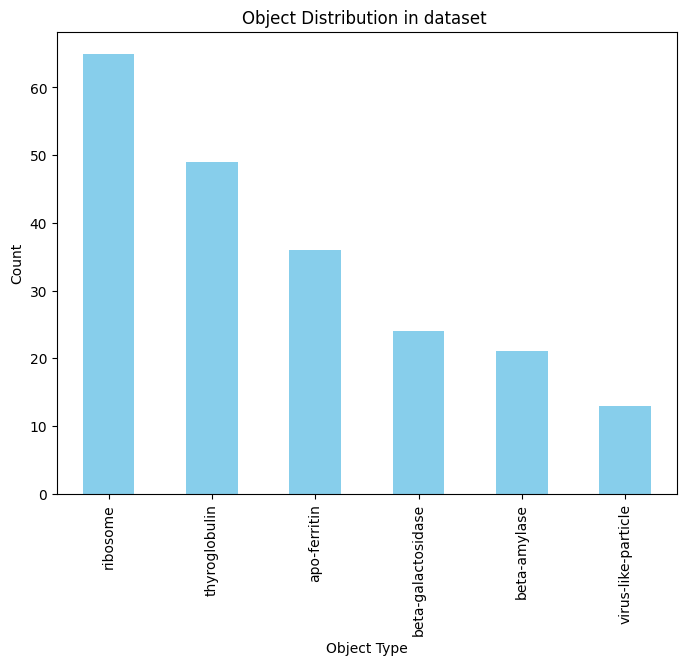

In [ ]:
# Count occurrences of each object type
object_counts = df['pickable_object_name'].value_counts()

# Plot the distribution of objects
plt.figure(figsize=(8, 6))
object_counts.plot(kind='bar', color='skyblue')
plt.title('Object Distribution in dataset ')
plt.xlabel('Object Type')
plt.ylabel('Count')
plt.show()

## Visualize Centroids in 3D

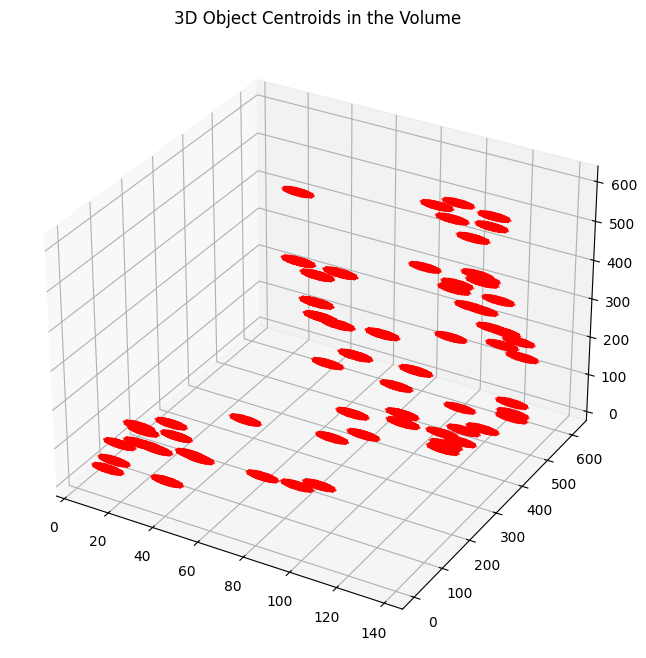

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
centroids = np.argwhere(voxel_labels_blob == 1)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=1)
ax.set_title('3D Object Centroids in the Volume')
plt.show()

## Visualize Subvolumes (Slices)

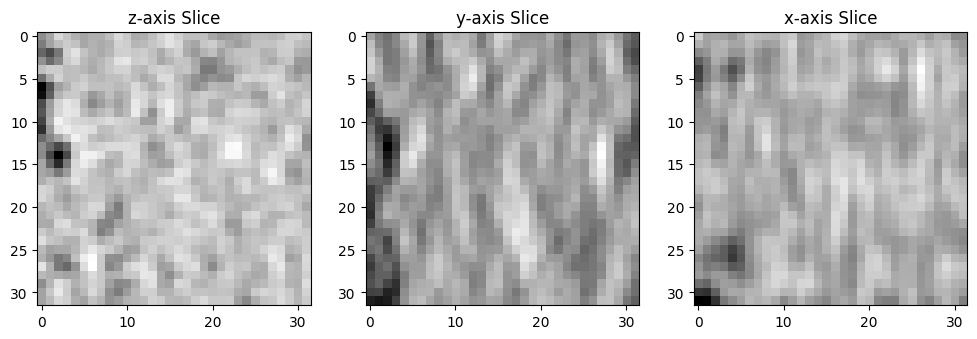

In [ ]:
# Randomly select a subvolume and show slices along each axis
idx = np.random.randint(0, len(filtered_volumes))
subvolume = filtered_volumes[idx]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, axis in enumerate(['z', 'y', 'x']):
    slice_idx = subvolume.shape[i] // 2
    axes[i].imshow(np.take(subvolume, slice_idx, axis=i), cmap='gray')
    axes[i].set_title(f'{axis}-axis Slice')
plt.show()

In [ ]:
PARTICLE_NAME = 'ribosome' # apo-ferritin, beta-amylase, beta-galactosidase, ribosome, thyroglobulin, virus-like-particle

In [ ]:
zarr_store = read_zarr(runs[6])
tomogram = zarr_store['0'][:]

In [ ]:
PARTICLE_PATH = f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{runs[6]}/Picks/{PARTICLE_NAME}.json"

with open(PARTICLE_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
coords = []

for point in data['points']:

    point_x = point['location']['x']/10
    point_y = point['location']['y']/10
    point_z = point['location']['z']//10

    coords.append([point_x, point_y, point_z])

coords = sorted(coords, key=lambda x: x[2])

In [ ]:
for coord in coords:
    plt.imshow(tomogram[int(coord[2]), :, :], cmap='gray')
    plt.scatter(coord[0], coord[1], edgecolors='red', facecolors='none')
    plt.title(f'{runs[6]} {PARTICLE_NAME} z={int(coord[2])}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 5) 3D U-Net Model

In [ ]:
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv3d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, scale_factor=2, mode='trilinear', align_corners=True)
        return x

## DataLoader and Training

In [ ]:
# Prepare DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = TensorDataset(torch.tensor(filtered_volumes), torch.tensor(filtered_labels))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize Model, Optimizer, Loss
model = UNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Training Loop
for epoch in range(500):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.unsqueeze(1).float().to(device), labels.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)  # Upsample
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

Epoch 10, Loss: 1.6278
Epoch 20, Loss: 1.5112
Epoch 30, Loss: 1.3366
Epoch 40, Loss: 1.2124
Epoch 50, Loss: 1.1504
Epoch 60, Loss: 1.1178
Epoch 70, Loss: 1.1222
Epoch 80, Loss: 1.1169
Epoch 90, Loss: 1.1185
Epoch 100, Loss: 1.0780
Epoch 110, Loss: 1.0716
Epoch 120, Loss: 1.0731
Epoch 130, Loss: 1.0554
Epoch 140, Loss: 1.0497
Epoch 150, Loss: 1.0521
Epoch 160, Loss: 1.0678
Epoch 170, Loss: 1.0416
Epoch 180, Loss: 1.0191
Epoch 190, Loss: 1.0672
Epoch 200, Loss: 1.0294
Epoch 210, Loss: 1.0125
Epoch 220, Loss: 1.0296
Epoch 230, Loss: 1.0102
Epoch 240, Loss: 1.0279
Epoch 250, Loss: 1.0677
Epoch 260, Loss: 1.0069
Epoch 270, Loss: 1.0357
Epoch 280, Loss: 1.0706
Epoch 290, Loss: 0.9985
Epoch 300, Loss: 0.9978
Epoch 310, Loss: 0.9964
Epoch 320, Loss: 1.0165
Epoch 330, Loss: 1.0108
Epoch 340, Loss: 1.0079
Epoch 350, Loss: 0.9943
Epoch 360, Loss: 1.0119
Epoch 370, Loss: 0.9890
Epoch 380, Loss: 0.9950
Epoch 390, Loss: 0.9826
Epoch 400, Loss: 0.9742
Epoch 410, Loss: 1.0136
Epoch 420, Loss: 0.9883
E

# 6) Evaluate Model Performance

## Prediction Visualization and Metrics

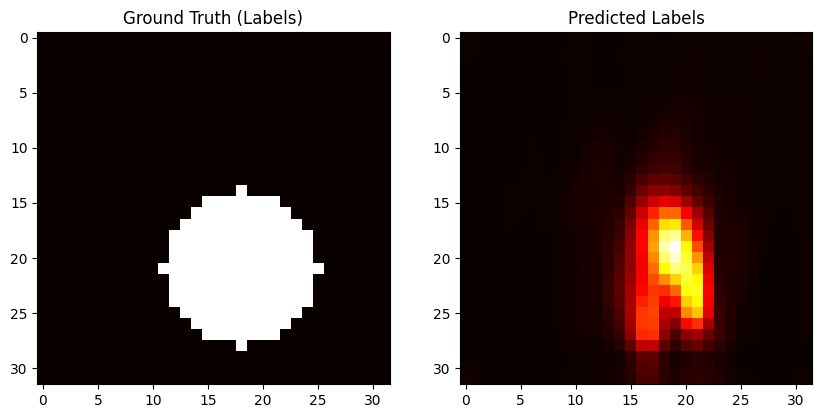

In [ ]:
# Example for calculating and visualizing predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    sample_input = torch.tensor(filtered_volumes[0]).unsqueeze(0).unsqueeze(1).float().to(device)  # Get one sample
    predicted = model(sample_input).cpu().numpy()

# Take the middle slice along the z-axis
predicted_slice = np.take(predicted[0], filtered_labels[0].shape[2] // 2, axis=2)
true_slice = np.take(filtered_labels[0], filtered_labels[0].shape[2] // 2, axis=2)

# Squeeze the extra dimension from the predictions
predicted_slice = np.squeeze(predicted_slice)

# Visualize the prediction and true label
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(true_slice, cmap='hot')
axes[0].set_title('Ground Truth (Labels)')
axes[1].imshow(predicted_slice, cmap='hot')
axes[1].set_title('Predicted Labels')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize variables to accumulate metrics across all batches
all_true_labels = []
all_predicted_labels = []

# Loop through the training or evaluation loop
for inputs, labels in train_loader:  # Use the appropriate DataLoader (train_loader or test_loader)
    inputs, labels = inputs.unsqueeze(1).float().to(device), labels.unsqueeze(1).float().to(device)
    outputs = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)

    # Flatten the labels and predictions for this batch
    all_true_labels.append(labels.flatten().cpu().numpy())
    all_predicted_labels.append((outputs.flatten() > 0.5).cpu().numpy())  # Binary classification (threshold at 0.5)

# Concatenate the lists into arrays
all_true_labels = np.concatenate(all_true_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)

# Now compute the metrics for the entire dataset
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.5894
Recall: 0.2131
F1 Score: 0.3131


Next Steps:

* Continue improving preprocessing by experimenting with different subvolume sizes and background fraction.

* Visualize model performance with more slices and 3D blobs.

* Experiment with different models (e.g., adding more layers or using different loss functions like Dice Loss for imbalanced data).

# Grid of experiements and particles

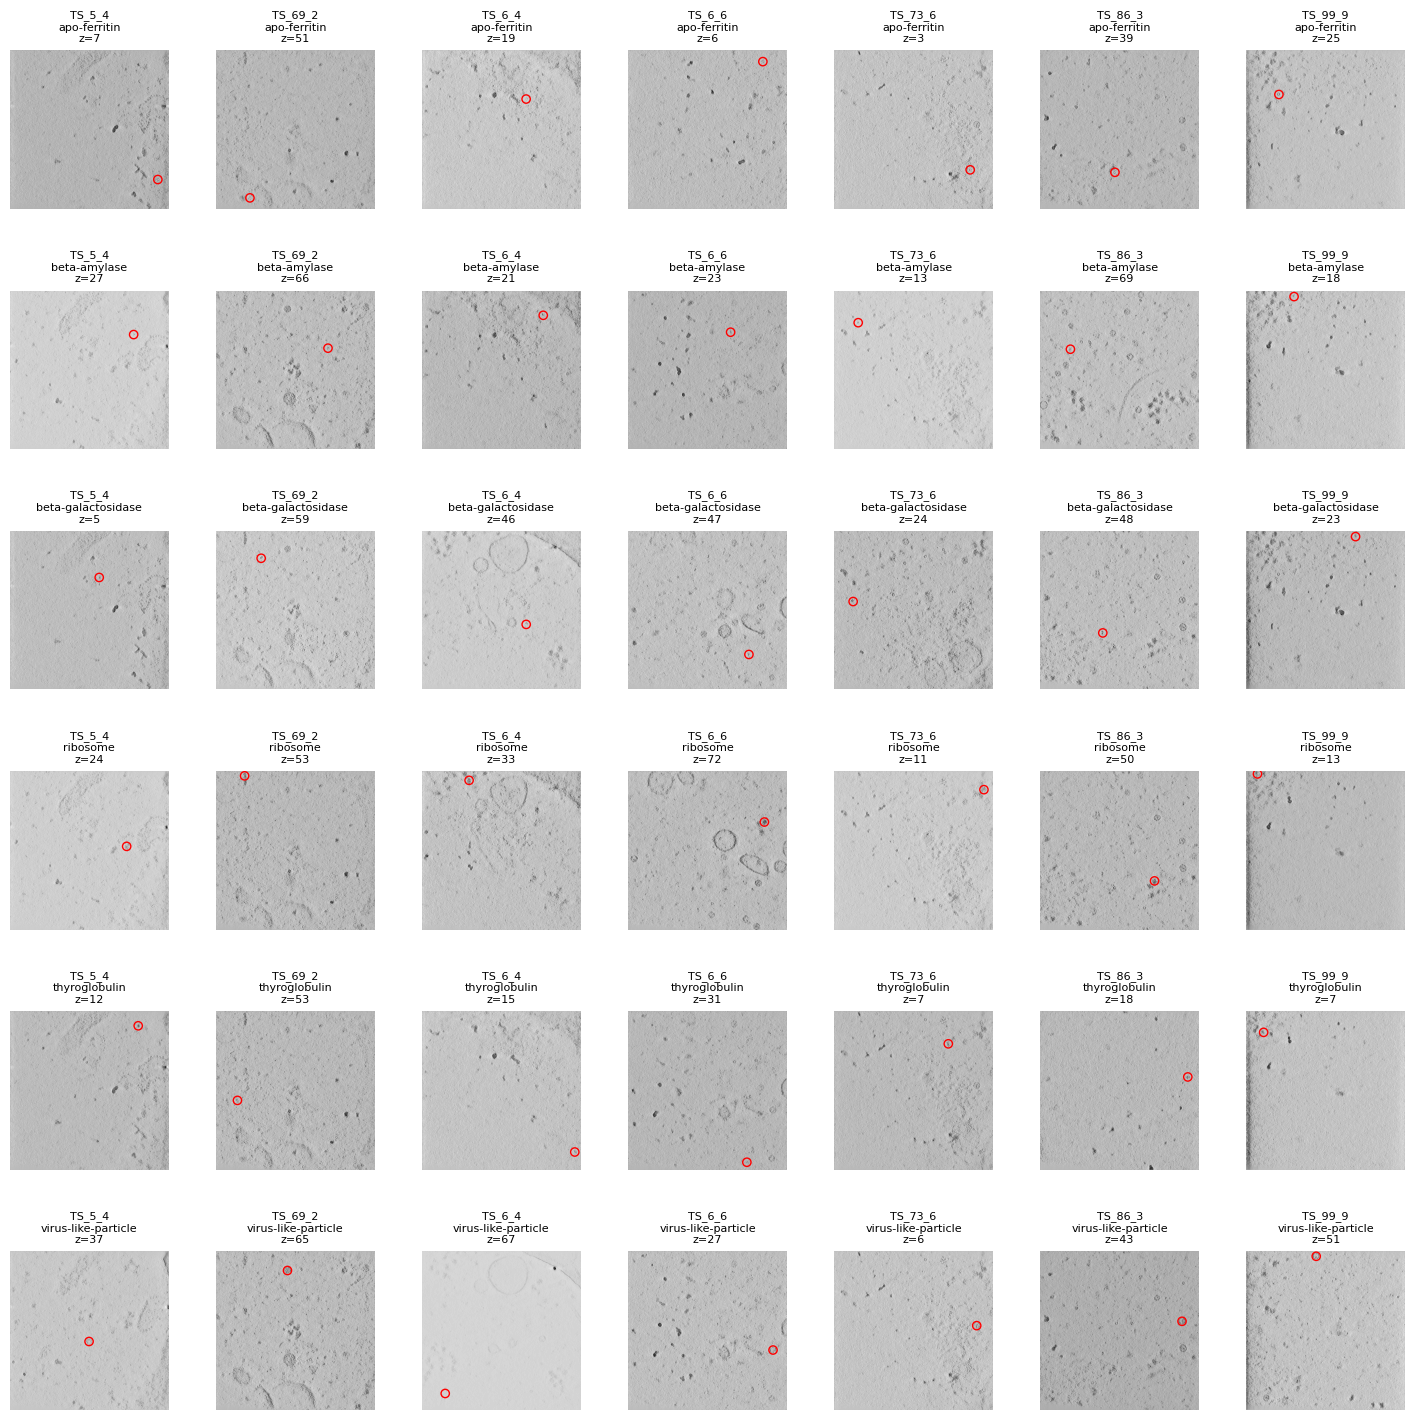

In [ ]:
import json
import matplotlib.pyplot as plt
import zarr

# Function to read zarr data
def read_zarr(run: str):
    """Reads a zarr data (we only use the denoised.zarr files)"""
    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

# Particle and run definitions
particles = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']
runs = ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

# Set up a figure for displaying images in grid format
fig, axs = plt.subplots(len(particles), len(runs), figsize=(18, 18))  # Increased figure size slightly
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Decreased spacing between subplots

for run_index, run in enumerate(runs):  # Iterate through runs first
    zarr_store = read_zarr(run)  # Read zarr data for the current run
    tomogram = zarr_store['0'][:]  # Accessing the highest resolution data (resolution '0')

    for particle_index, PARTICLE_NAME in enumerate(particles):  # Iterate through particles
        # Read particle coordinates from JSON file
        PARTICLE_PATH = f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/{PARTICLE_NAME}.json"

        try:
            with open(PARTICLE_PATH, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except FileNotFoundError:
            print(f"Warning: No data found for {PARTICLE_NAME} in run {run}")
            axs[particle_index, run_index].axis('off')  # Turn off the axis if no data is found
            axs[particle_index, run_index].set_title(f"{run}\n{PARTICLE_NAME}\nNo Data", fontsize=8)
            continue

        # Extract coordinates and sort them
        coords = []
        for point in data['points']:
            point_x = point['location']['x'] / 10
            point_y = point['location']['y'] / 10
            point_z = point['location']['z'] // 10
            coords.append([point_x, point_y, point_z])
        coords = sorted(coords, key=lambda x: x[2])

        # Select the first coordinate if available
        if len(coords) > 0:
            coord = coords[0]
            z_index = int(coord[2])

            # Plot the tomogram slice with the selected particle
            axs[particle_index, run_index].imshow(tomogram[z_index, :, :], cmap='gray')
            axs[particle_index, run_index].scatter(coord[0], coord[1], edgecolors='red', facecolors='none')
            axs[particle_index, run_index].set_title(f"{run}\n{PARTICLE_NAME}\nz={z_index}", fontsize=8)
            axs[particle_index, run_index].axis('off')
        else:
            axs[particle_index, run_index].axis('off')
            axs[particle_index, run_index].set_title(f"{run}\n{PARTICLE_NAME}\nNo Particles", fontsize=8)

plt.show()


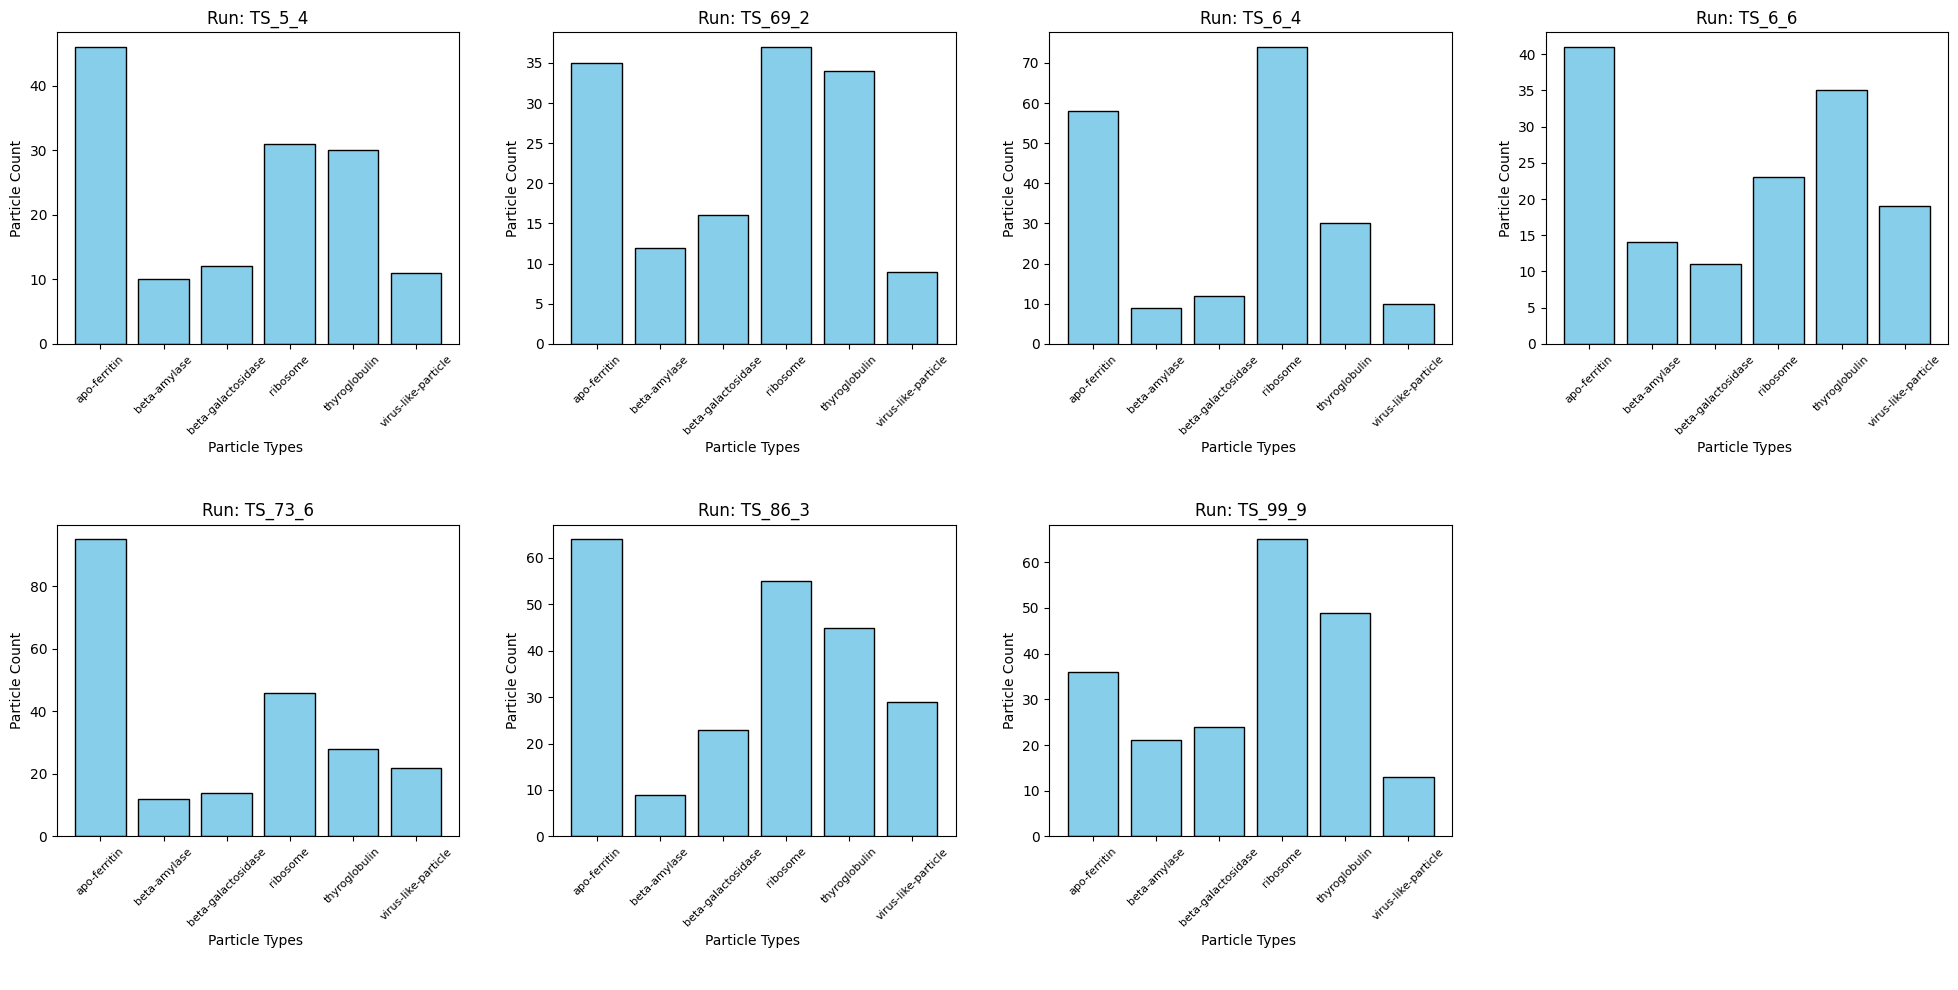

In [ ]:
import json
import matplotlib.pyplot as plt
import os

# Particle and run definitions
particles = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']
runs = ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

# Define the grid layout (2 rows, 4 columns)
rows = 2  # Number of rows
cols = 4  # Number of columns

# Create the figure and axes
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))  # Adjust the figure size to accommodate more plots
fig.subplots_adjust(hspace=20.0, wspace=8.5)  # Adjust spacing between subplots

# Flatten the axes array for easy indexing
axs = axs.flatten()

# Loop through each run and plot the particle counts
for run_index, run in enumerate(runs):
    particle_counts = []  # Store the count of particles for each type

    for PARTICLE_NAME in particles:
        # Construct path to the JSON file
        PARTICLE_PATH = f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/{PARTICLE_NAME}.json"

        # Check if the file exists and load it
        if os.path.exists(PARTICLE_PATH):
            with open(PARTICLE_PATH, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Count the number of particles (points) for the current particle type
                particle_counts.append(len(data['points']))
        else:
            # If file doesn't exist, append 0 to counts
            particle_counts.append(0)

    # Plot the bar chart in the corresponding subplot
    ax = axs[run_index]
    ax.bar(particles, particle_counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Run: {run}", fontsize=12)
    ax.set_xlabel("Particle Types \n \n", fontsize=10)
    ax.set_ylabel("Particle Count", fontsize=10)
    ax.set_xticks(range(len(particles)))
    ax.set_xticklabels(particles, rotation=45, fontsize=8)

# Turn off any unused axes (for the second row's 1 unused plot)
for i in range(len(runs), len(axs)):
    axs[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import zarr
import os
from glob import glob

# Function to read Zarr data
def read_zarr(run: str) -> zarr.hierarchy.Group:
    """Reads a zarr data (we only use the denoised.zarr files)"""
    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

# Function to read and process the JSON files containing particle centroid information
def read_run(run: str) -> pd.DataFrame:
    """Creates a dataframe with the coordinates of the centroids of the particles."""
    paths = glob(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json")
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    return df

# Function to map overlay (from JSON) to a voxel grid, given the voxel spacing and particle type
def map_overlay_to_voxels(df, particle_type, voxel_spacing=10, volume_shape=(100, 100, 100)):
    """Creates a 3D image (volume) using the dataframe about centroids of specified particles."""
    voxel_labels = np.zeros(volume_shape, dtype=int)
    for _, row in df.iterrows():
        x, y, z = [int(row[axis] / voxel_spacing) for axis in ['x', 'y', 'z']]
        # Assign voxel value based on the specified particle type
        voxel_labels[z, y, x] = 1 if row['pickable_object_name'] == particle_type else 0
    return voxel_labels

# Function to expand labeled centroids into spherical blobs in the voxel grid
def expand_labels_with_blobs(voxel_labels, radius):
    """Expands labeled centroids (value = 1) in a 3D numpy array into spherical blobs."""
    radius = int(radius)
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    sphere = distance <= radius

    expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
    centroids = np.argwhere(voxel_labels == 1)

    for centroid in centroids:
        cz, cy, cx = centroid
        z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
        y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
        x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
        roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
        roi[sphere] = 1
    return expanded_labels

# Creates a list with the names of the experiments (runs)
runs = sorted(glob('/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
print(runs)

# List of particle types to loop through
particles = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

# Iterate through runs and particles
for run in runs:
    print(f"Processing {run}...")

    # Read the Zarr data for the current run
    zarr_data_nparray = read_zarr(run)

    # Read the DataFrame containing particle centroid data for the current run
    df = read_run(run)

    # Set up the grid of subplots (6 rows, 1 column)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': '3d'})

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each particle type and plot the results in the grid
    for i, particle_name in enumerate(particles):
        print(f"  Processing {particle_name}...")

        # Map overlay to voxels and create voxel labels for the selected particle
        voxel_labels = map_overlay_to_voxels(df, particle_type=particle_name, voxel_spacing=10, volume_shape=zarr_data_nparray["0"].shape)

        # Expand the voxel labels into spherical blobs
        radius = 3  # Radius in voxels for expanding the blobs
        voxel_labels_blob = expand_labels_with_blobs(voxel_labels, radius=radius)

        # Visualize the expanded blob centroids in 3D in the corresponding subplot
        centroids = np.argwhere(voxel_labels_blob == 1)
        ax = axes[i]
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=1)
        ax.set_title(f'{particle_name}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    # Show the plot with the grid of subplots for the current run
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']


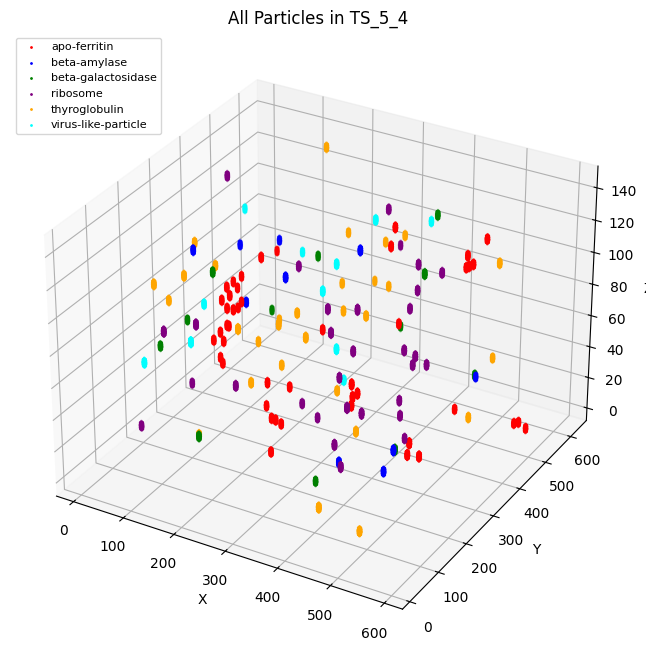

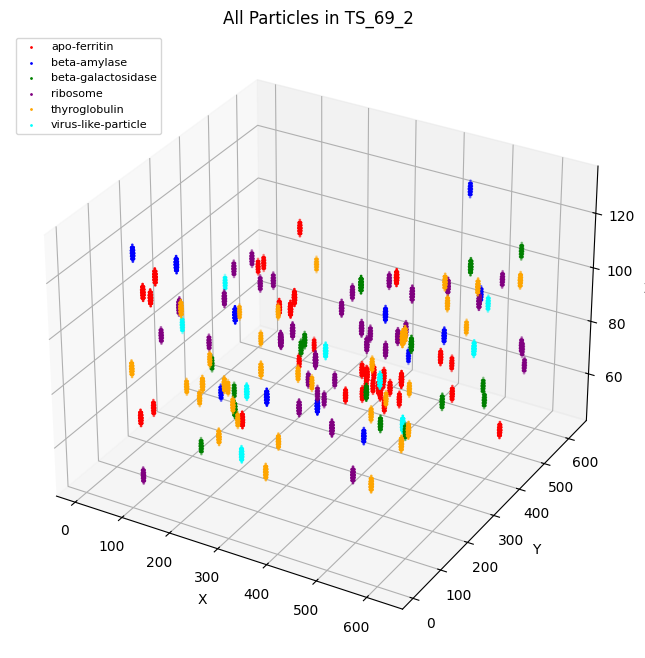

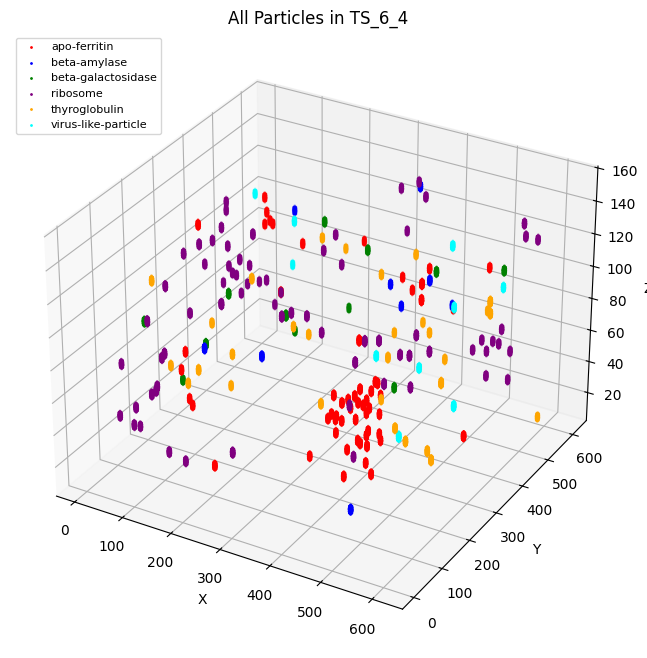

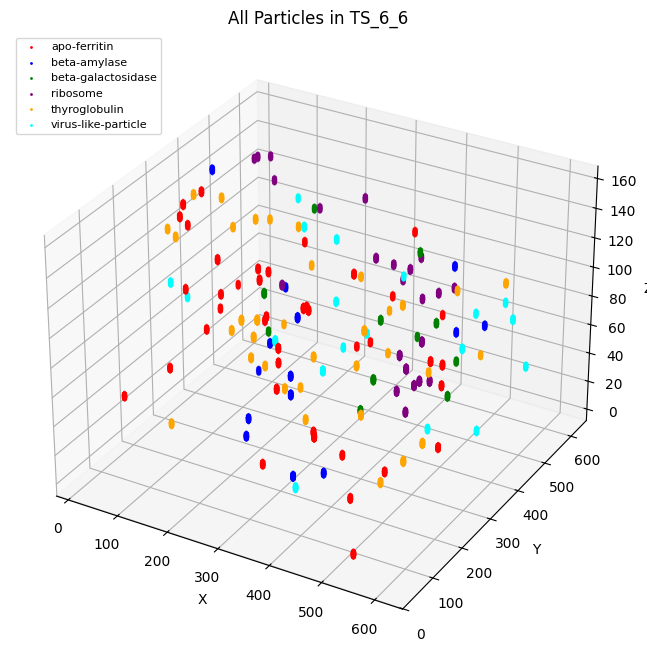

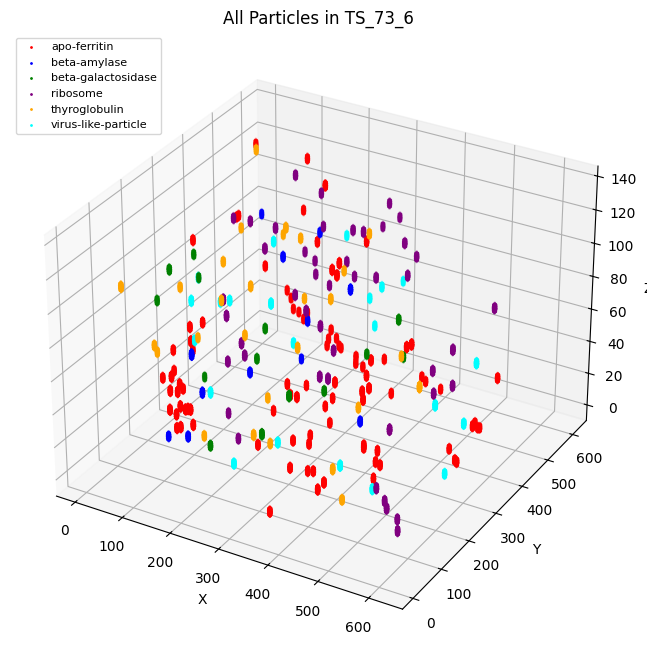

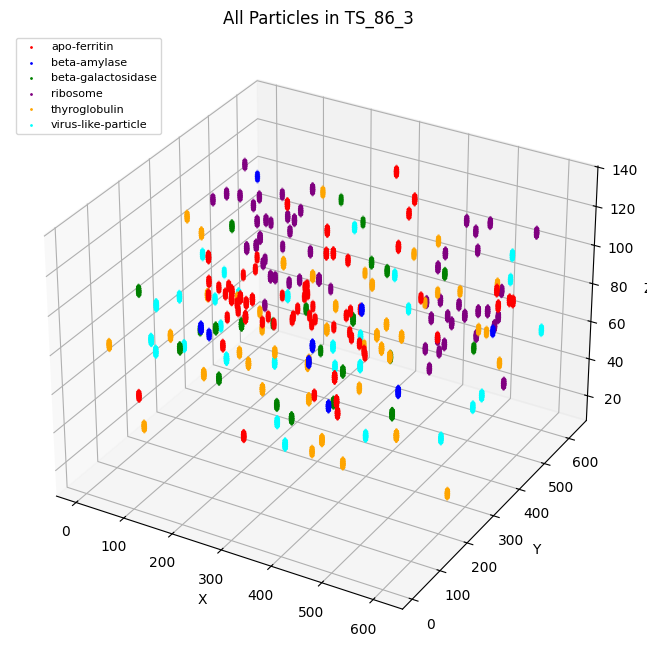

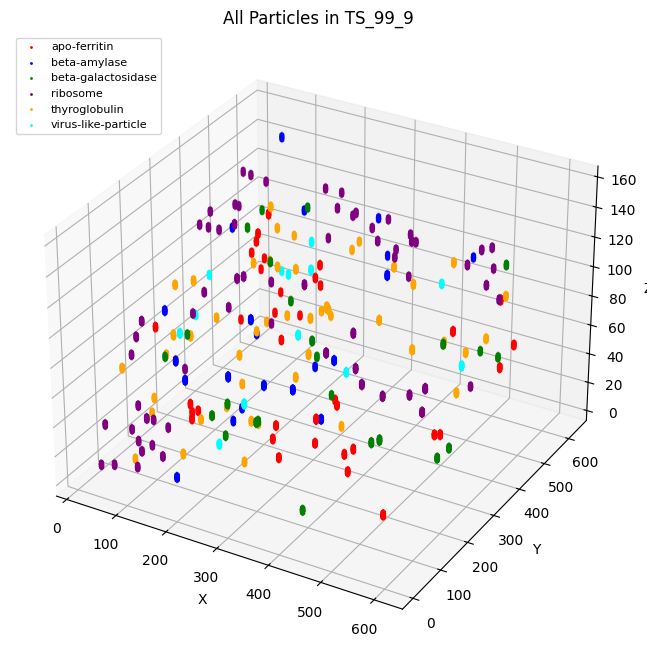

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import zarr
import os
from glob import glob

# Function to read Zarr data
def read_zarr(run: str) -> zarr.hierarchy.Group:
    """Reads a zarr data (we only use the denoised.zarr files)"""
    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

# Function to read and process the JSON files containing particle centroid information
def read_run(run: str) -> pd.DataFrame:
    """Creates a dataframe with the coordinates of the centroids of the particles."""
    paths = glob(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json")
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    return df

# Function to map overlay (from JSON) to a voxel grid, given the voxel spacing and particle type
def map_overlay_to_voxels(df, particle_type, voxel_spacing=10, volume_shape=(100, 100, 100)):
    """Creates a 3D image (volume) using the dataframe about centroids of specified particles."""
    voxel_labels = np.zeros(volume_shape, dtype=int)
    for _, row in df.iterrows():
        x, y, z = [int(row[axis] / voxel_spacing) for axis in ['x', 'y', 'z']]
        # Assign voxel value based on the specified particle type
        voxel_labels[z, y, x] = 1 if row['pickable_object_name'] == particle_type else 0
    return voxel_labels

# Function to expand labeled centroids into spherical blobs in the voxel grid
def expand_labels_with_blobs(voxel_labels, radius):
    """Expands labeled centroids (value = 1) in a 3D numpy array into spherical blobs."""
    radius = int(radius)
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    sphere = distance <= radius

    expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
    centroids = np.argwhere(voxel_labels == 1)

    for centroid in centroids:
        cz, cy, cx = centroid
        z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
        y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
        x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
        roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
        roi[sphere] = 1
    return expanded_labels

# Creates a list with the names of the experiments (runs)
runs = sorted(glob('/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
print(runs)

# List of particle types to loop through (6 particles)
particles = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

# Iterate through runs
for run in runs:
    # Read the Zarr data for the current run
    zarr_data_nparray = read_zarr(run)

    # Read the DataFrame containing particle centroid data for the current run
    df = read_run(run)

    # Set up a single 3D plot for all particle types combined
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for different particles (one color per particle)
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']

    # Iterate over each particle type and add the results to the same 3D plot
    for i, particle_name in enumerate(particles):
      # Map overlay to voxels and create voxel labels for the selected particle
      voxel_labels = map_overlay_to_voxels(df, particle_type=particle_name, voxel_spacing=10, volume_shape=zarr_data_nparray["0"].shape)

      # Expand the voxel labels into spherical blobs
      radius = 3  # Radius in voxels for expanding the blobs
      voxel_labels_blob = expand_labels_with_blobs(voxel_labels, radius=radius)

      # Visualize the expanded blob centroids in 3D on the same plot
      centroids = np.argwhere(voxel_labels_blob == 1)
      ax.scatter(centroids[:, 2], centroids[:, 1], centroids[:, 0], c=colors[i], s=1, label=particle_name)  # Switch x and z

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"All Particles in {run}")
    ax.legend(loc='upper left', fontsize=8)

    # Show the combined 3D plot
    plt.show()
